In [1]:
!pip install numpy
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 1.7 MB/s eta 0:00:00a 0:00:01
Defaulting to user installation because normal site-packages is not writeable


In [4]:
import tensorflow as tf
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import Model
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

2.13.0
Epoch 1/100
309/309 [==============================] - 12s 25ms/step - loss: 3.9566 - accuracy: 0.2691 - val_loss: 4.7279 - val_accuracy: 0.1557
Epoch 2/100
309/309 [==============================] - 8s 25ms/step - loss: 2.9526 - accuracy: 0.3612 - val_loss: 3.2079 - val_accuracy: 0.2988
Epoch 3/100
309/309 [==============================] - 8s 27ms/step - loss: 2.3402 - accuracy: 0.4158 - val_loss: 2.8547 - val_accuracy: 0.2831
Epoch 4/100
309/309 [==============================] - 8s 25ms/step - loss: 1.9409 - accuracy: 0.4706 - val_loss: 3.4417 - val_accuracy: 0.2598
Epoch 5/100
309/309 [==============================] - 8s 26ms/step - loss: 1.7000 - accuracy: 0.5114 - val_loss: 1.9664 - val_accuracy: 0.4417
Epoch 6/100
309/309 [==============================] - 8s 25ms/step - loss: 1.5665 - accuracy: 0.5383 - val_loss: 1.8410 - val_accuracy: 0.4574
Epoch 7/100
309/309 [==============================] - 8s 26ms/step - loss: 1.4587 - accuracy: 0.5711 - val_loss: 1.8235 - val_a

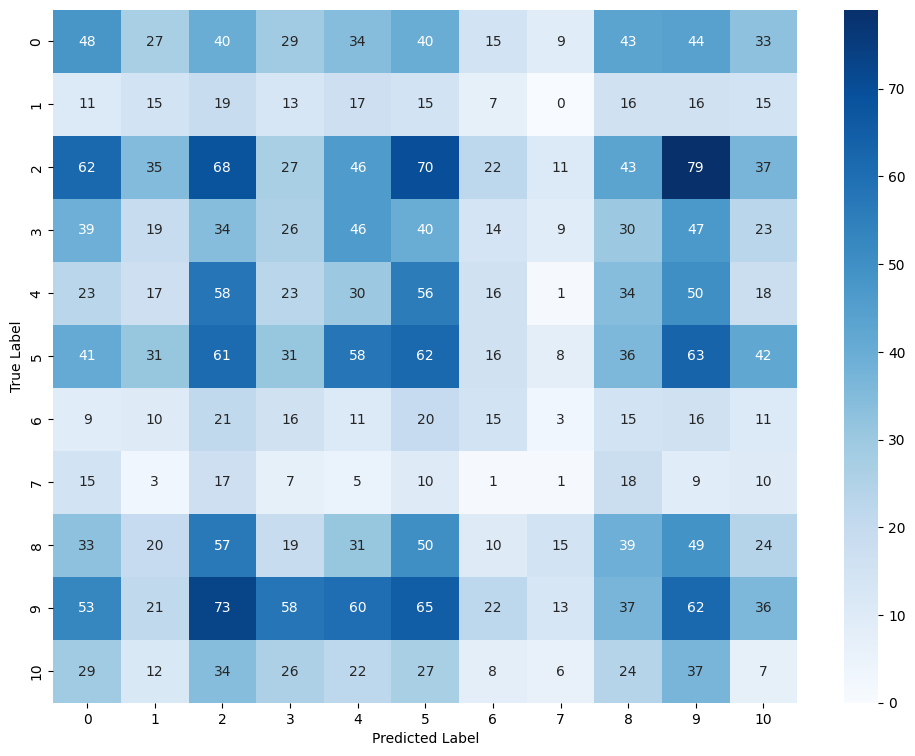

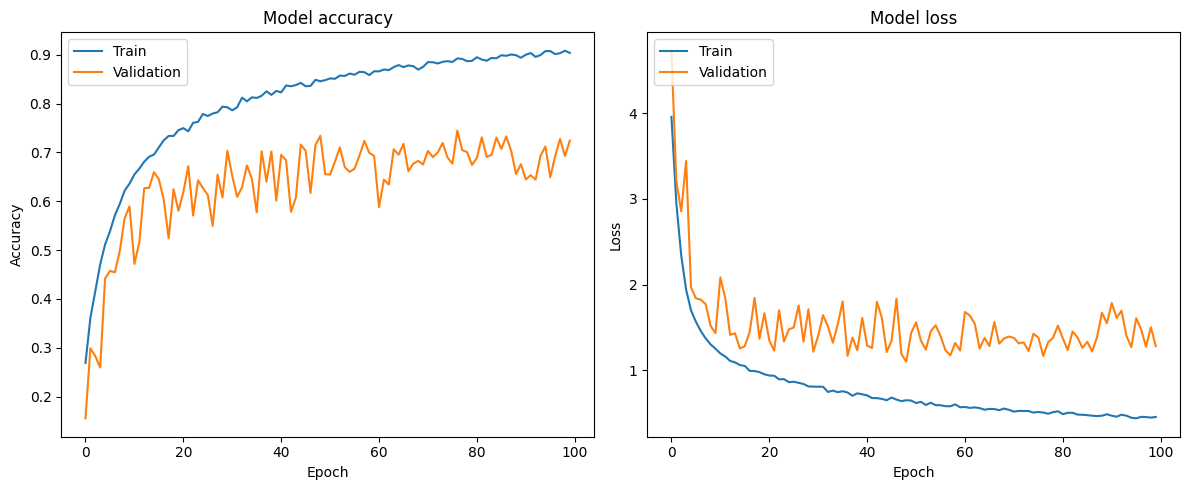

In [9]:
# 72%
# Constants
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
TRAINING_DIR = "training"
VALIDATION_DIR = "validation"
NUM_CLASSES = 11
print(tf.__version__)


#0 is bread, 1 is diary products, 2 is dessert, 3 is eggs, 4 is fast food, 5 is meat, 
#6 is pasta/noodles, 7 is rise, 8 is seafoods, 9 is soup, 10 is Vegetable/Fruit

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    file_name_parts = tf.strings.split(parts[-1], '_')
    return tf.strings.to_number(file_name_parts[0], out_type=tf.int32)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img /= 255.0
    return img, label

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

train_dataset = tf.data.Dataset.list_files(os.path.join(TRAINING_DIR, '*_*.jpg'))
train_dataset = train_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.list_files(os.path.join(VALIDATION_DIR, '*_*.jpg'))
validation_dataset = validation_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(*IMAGE_SIZE, 3)),
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

early_stopping = tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, callbacks=[early_stopping])

y_pred_probs = model.predict(validation_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y.numpy() for _, y in validation_dataset], axis=0)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


2.13.0
Epoch 1/10
309/309 [==============================] - 10s 26ms/step - loss: 2.0197 - accuracy: 0.2909 - val_loss: 1.8165 - val_accuracy: 0.3668
Epoch 2/10
309/309 [==============================] - 8s 25ms/step - loss: 1.6640 - accuracy: 0.4202 - val_loss: 1.6083 - val_accuracy: 0.4408
Epoch 3/10
309/309 [==============================] - 8s 26ms/step - loss: 1.3286 - accuracy: 0.5412 - val_loss: 1.5417 - val_accuracy: 0.4706
Epoch 4/10
309/309 [==============================] - 8s 24ms/step - loss: 0.9494 - accuracy: 0.6759 - val_loss: 1.6429 - val_accuracy: 0.4889
Epoch 5/10
309/309 [==============================] - 8s 24ms/step - loss: 0.4688 - accuracy: 0.8449 - val_loss: 2.0091 - val_accuracy: 0.4825
Epoch 6/10
309/309 [==============================] - 8s 26ms/step - loss: 0.1506 - accuracy: 0.9554 - val_loss: 2.6797 - val_accuracy: 0.4945
Epoch 7/10
309/309 [==============================] - 8s 25ms/step - loss: 0.1054 - accuracy: 0.9690 - val_loss: 2.8695 - val_accuracy

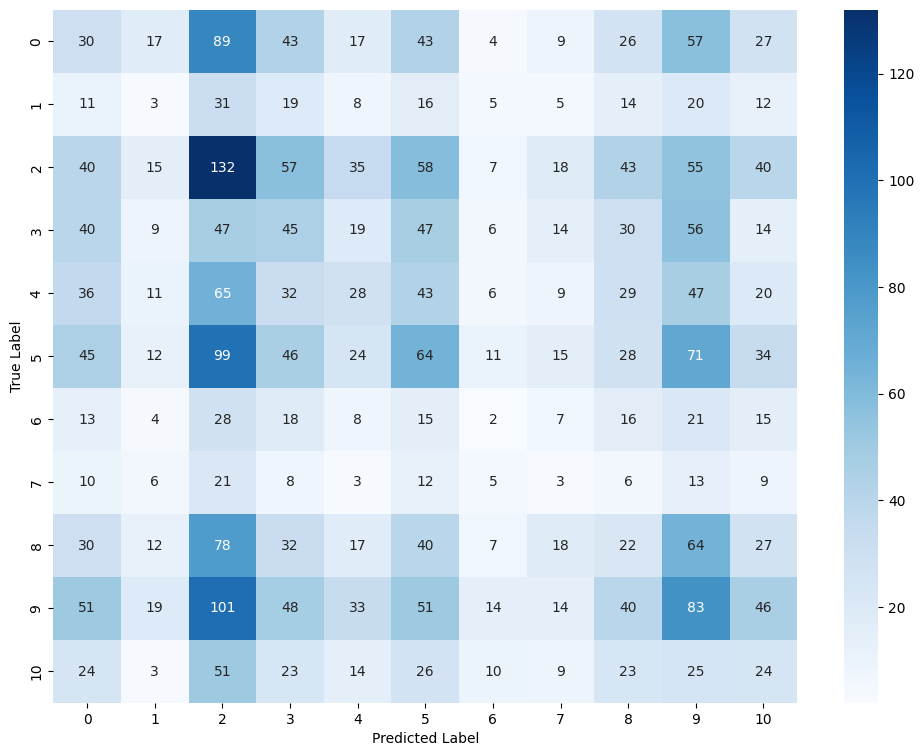

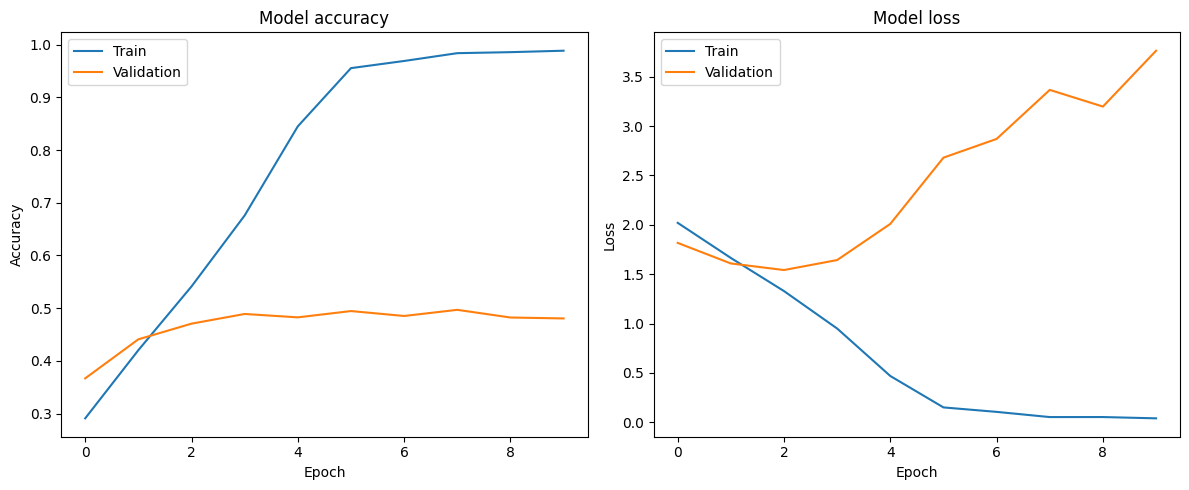

In [6]:
## 48 %
# Constants
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
TRAINING_DIR = "training"
VALIDATION_DIR = "validation"
NUM_CLASSES = 11
print(tf.__version__)
# Extract class ID from file path
def get_label(file_path):
    # Use TensorFlow's string operations
    parts = tf.strings.split(file_path, os.path.sep)
    # Get the last part (filename) and split it by '_'
    file_name_parts = tf.strings.split(parts[-1], '_')
    return tf.strings.to_number(file_name_parts[0], out_type=tf.int32)

# Load and preprocess image
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img /= 255.0  # Normalize to [0,1]
    return img, label

# Create datasets
train_dataset = tf.data.Dataset.list_files(os.path.join(TRAINING_DIR, '*_*.jpg'))
train_dataset = train_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.list_files(os.path.join(VALIDATION_DIR, '*_*.jpg'))
validation_dataset = validation_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

# Model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(*IMAGE_SIZE, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=10, validation_data=validation_dataset)


# Predict on the validation dataset
y_pred_probs = model.predict(validation_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)

# Extract true labels from the validation dataset
y_true = np.concatenate([y.numpy() for _, y in validation_dataset], axis=0)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


2.13.0
Epoch 1/10


2023-10-24 15:43:08.769461: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


309/309 [==============================] - 11s 27ms/step - loss: 4.1756 - accuracy: 0.2369 - val_loss: 4.1209 - val_accuracy: 0.1531 - lr: 0.0010
Epoch 2/10
309/309 [==============================] - 9s 28ms/step - loss: 3.0392 - accuracy: 0.3021 - val_loss: 2.7423 - val_accuracy: 0.2840 - lr: 0.0013
Epoch 3/10
309/309 [==============================] - 9s 28ms/step - loss: 2.3934 - accuracy: 0.3570 - val_loss: 6.8195 - val_accuracy: 0.0778 - lr: 0.0016
Epoch 4/10
309/309 [==============================] - 8s 27ms/step - loss: 2.0875 - accuracy: 0.3821 - val_loss: 2.5869 - val_accuracy: 0.2749 - lr: 0.0020
Epoch 5/10
309/309 [==============================] - 8s 27ms/step - loss: 1.9928 - accuracy: 0.3982 - val_loss: 2.0792 - val_accuracy: 0.3767 - lr: 0.0025
Epoch 6/10
309/309 [==============================] - 8s 26ms/step - loss: 1.9365 - accuracy: 0.4205 - val_loss: 2.0821 - val_accuracy: 0.3697 - lr: 0.0032
Epoch 7/10
309/309 [==============================] - 9s 28ms/step - loss:

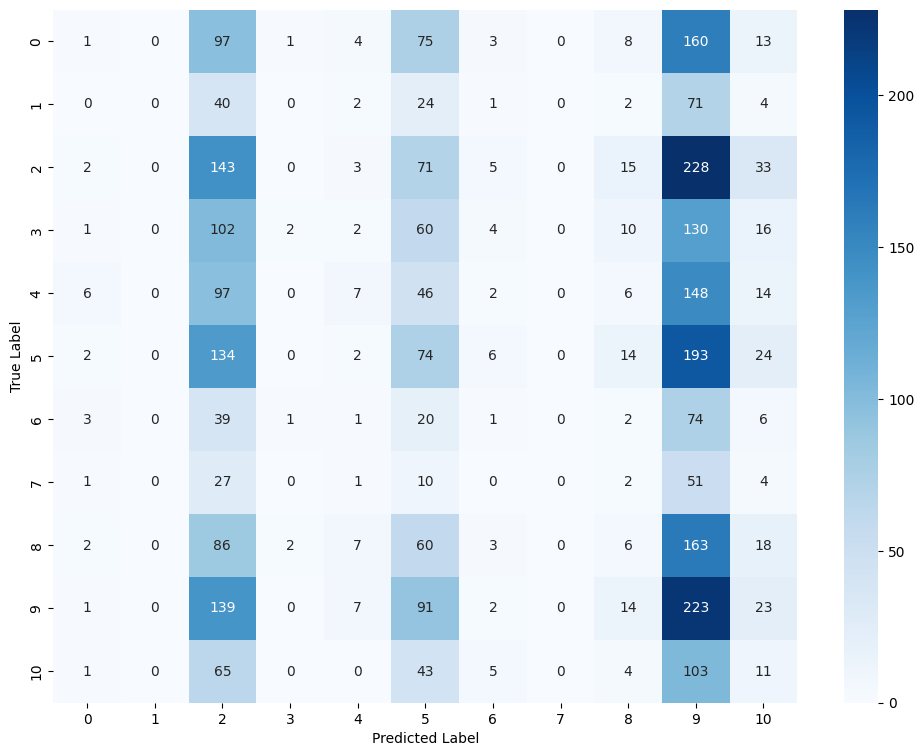

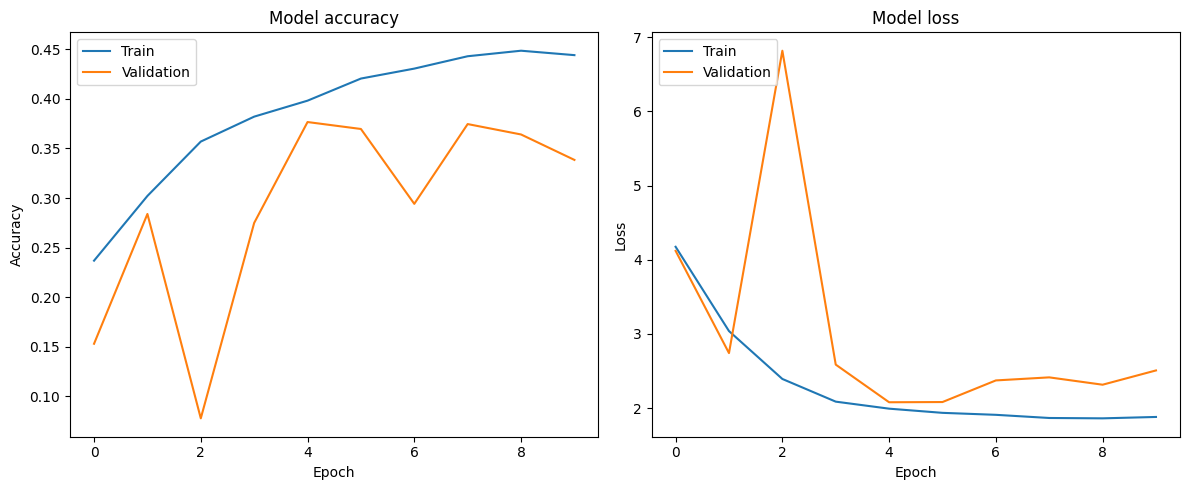

In [10]:
# 27%
# Constants
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
TRAINING_DIR = "training"
VALIDATION_DIR = "validation"
NUM_CLASSES = 11
print(tf.__version__)

# Extract class ID from file path
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    file_name_parts = tf.strings.split(parts[-1], '_')
    return tf.strings.to_number(file_name_parts[0], out_type=tf.int32)

# Load and preprocess image
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img /= 255.0  # Normalize to [0,1]
    return img, label

# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

# Create datasets
train_dataset = tf.data.Dataset.list_files(os.path.join(TRAINING_DIR, '*_*.jpg'))
train_dataset = train_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

validation_dataset = tf.data.Dataset.list_files(os.path.join(VALIDATION_DIR, '*_*.jpg'))
validation_dataset = validation_dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

# Model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(*IMAGE_SIZE, 3)),
    data_augmentation,
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Learning Rate Scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset, 
    epochs=10, 
    validation_data=validation_dataset, 
    callbacks=[lr_schedule, early_stopping]
)

# Predict on the validation dataset
y_pred_probs = model.predict(validation_dataset)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y.numpy() for _, y in validation_dataset], axis=0)
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()
